In [2]:
library(dplyr)
library(edgeR)
library(readr)
library(rtracklayer)
library(satuRn)
library(SummarizedExperiment)

In [3]:
tcga_groups <- readxl::read_excel("../data/processed/tcga_groups.xlsx")

tcga_groups = tcga_groups %>%
    dplyr::filter(normal > 20)

tcga_groups = tcga_groups$project

In [4]:
gtf <- rtracklayer::import("../data/raw/gencode.v23.annotation.gtf.gz")
gtf = dplyr::as_tibble(gtf)

gtf = gtf %>%
    dplyr::filter(type == "transcript") %>%
    dplyr::select(transcript_id, gene_name) %>%
    dplyr::rename(isoform_id = transcript_id,
                  gene_id = gene_name) %>%
    na.omit()

Warning message:
"Zero sample variances detected, have been offset away from zero"


[1] "brca done."


Warning message:
"Zero sample variances detected, have been offset away from zero"


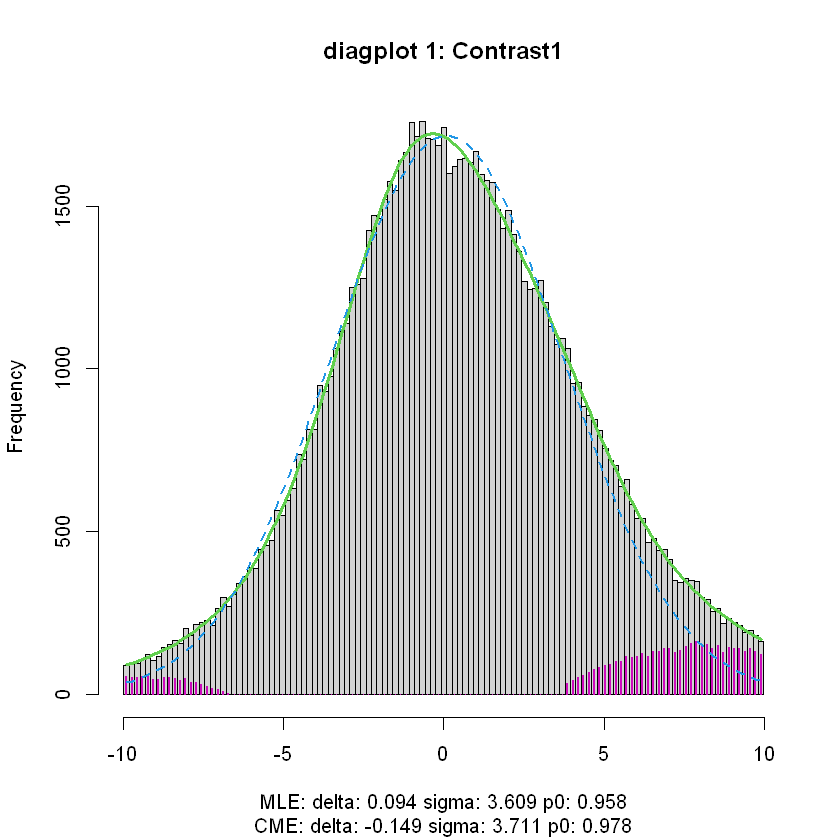

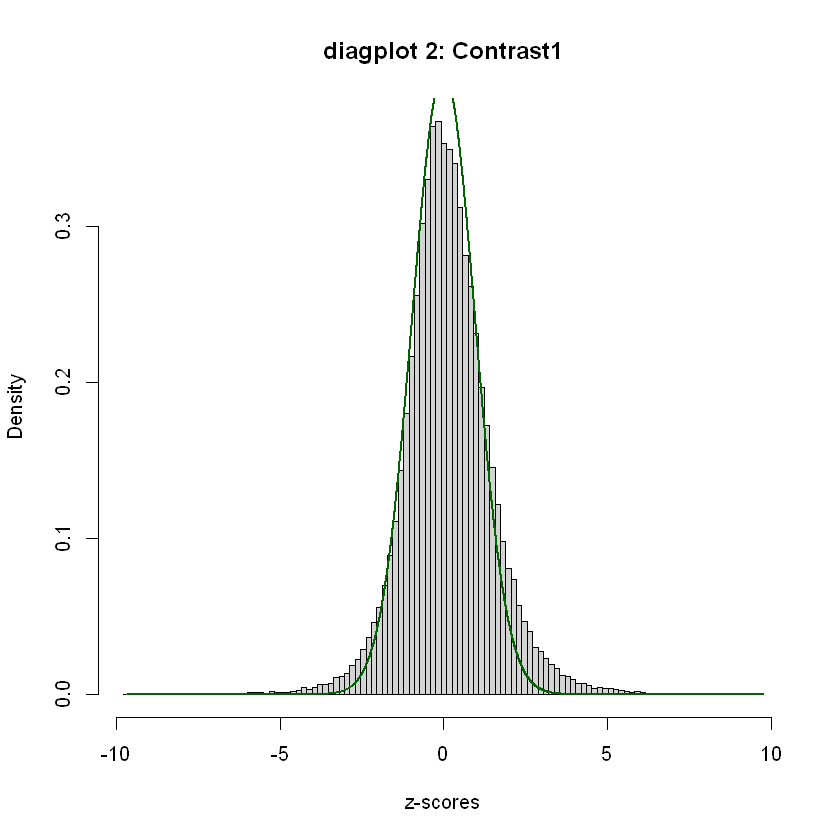

[1] "kirc done."


Warning message:
"Zero sample variances detected, have been offset away from zero"
Warning message in locfdr(zz = zvalues_mid, main = paste0("diagplot 1: ", main)):
"f(z) misfit = 1.5.  Rerun with increased df"


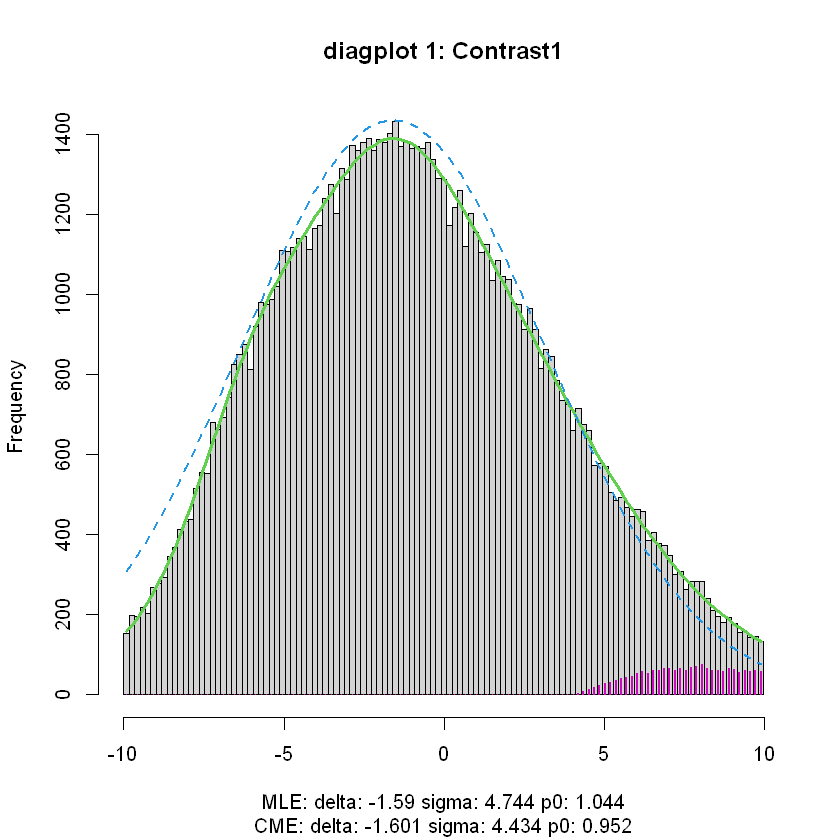

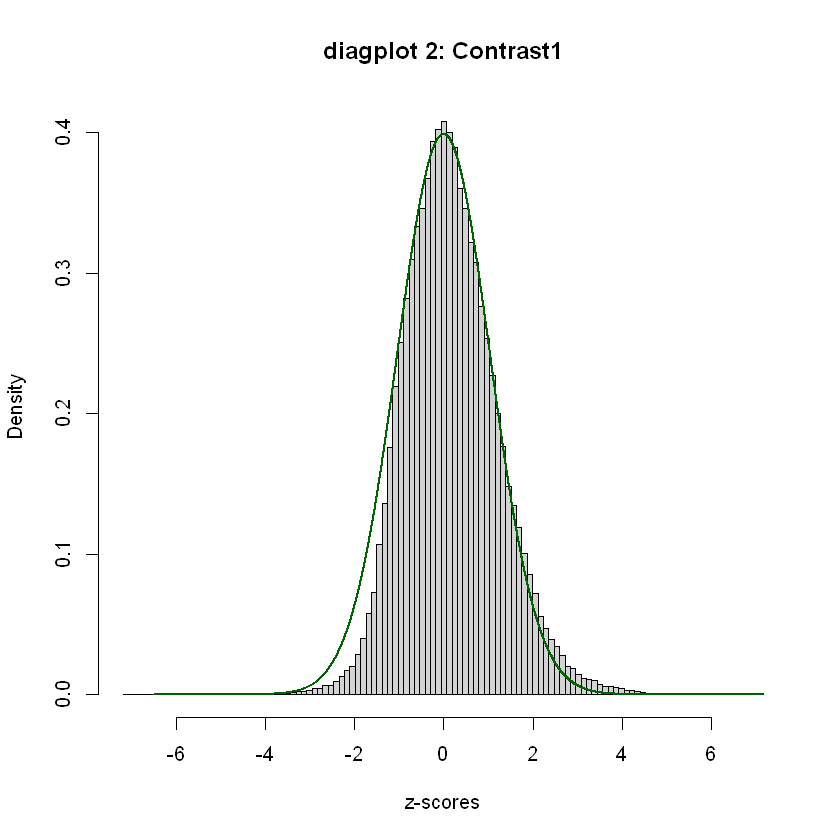

[1] "thca done."


Warning message:
"Zero sample variances detected, have been offset away from zero"


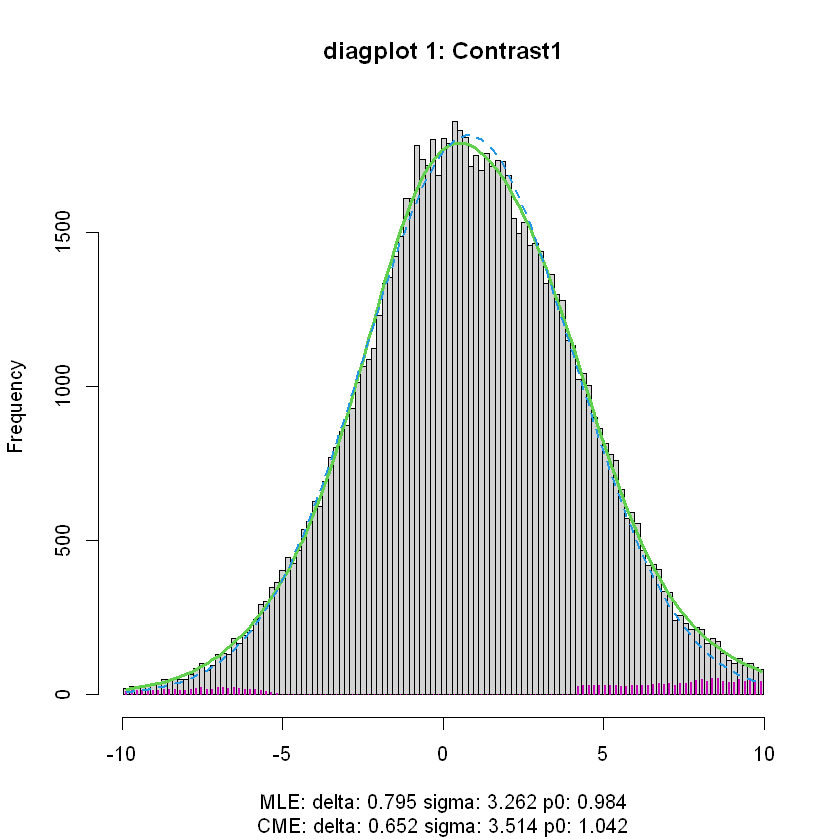

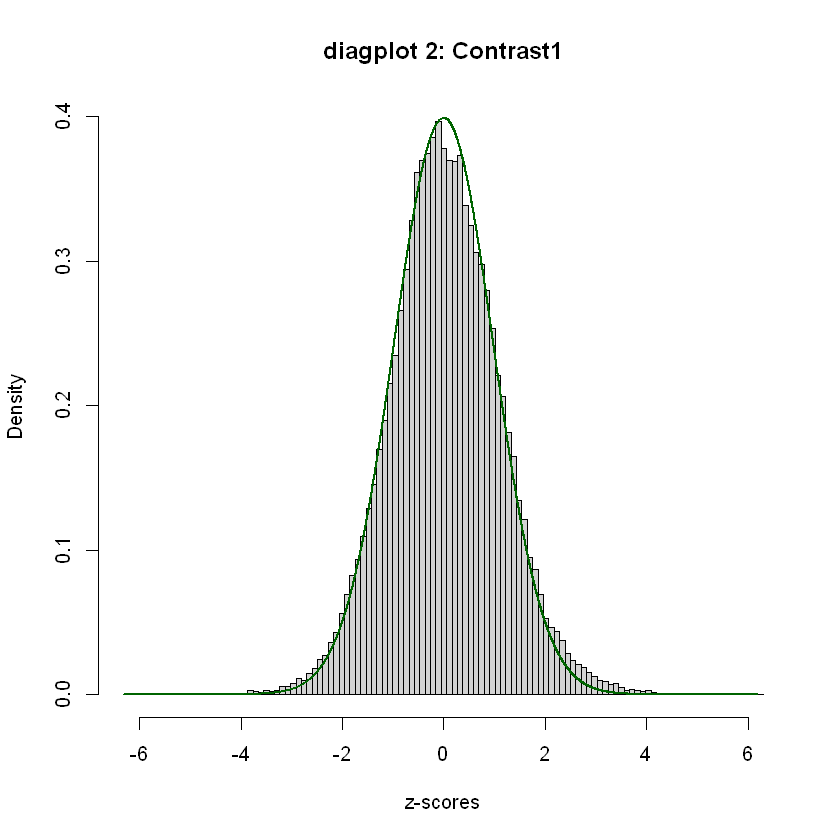

[1] "luad done."


Warning message:
"Zero sample variances detected, have been offset away from zero"


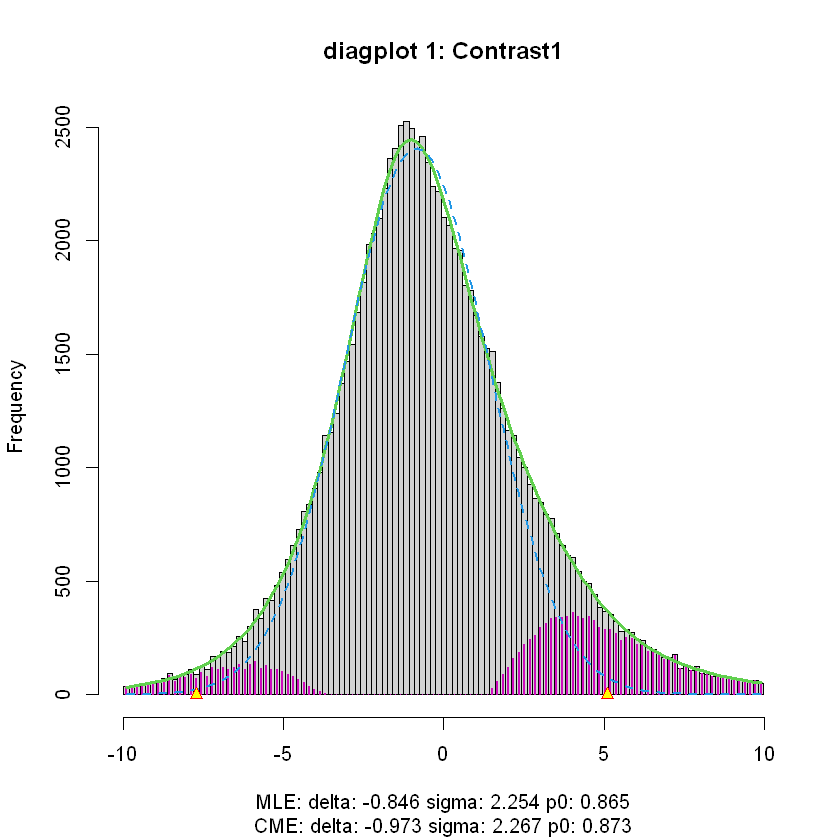

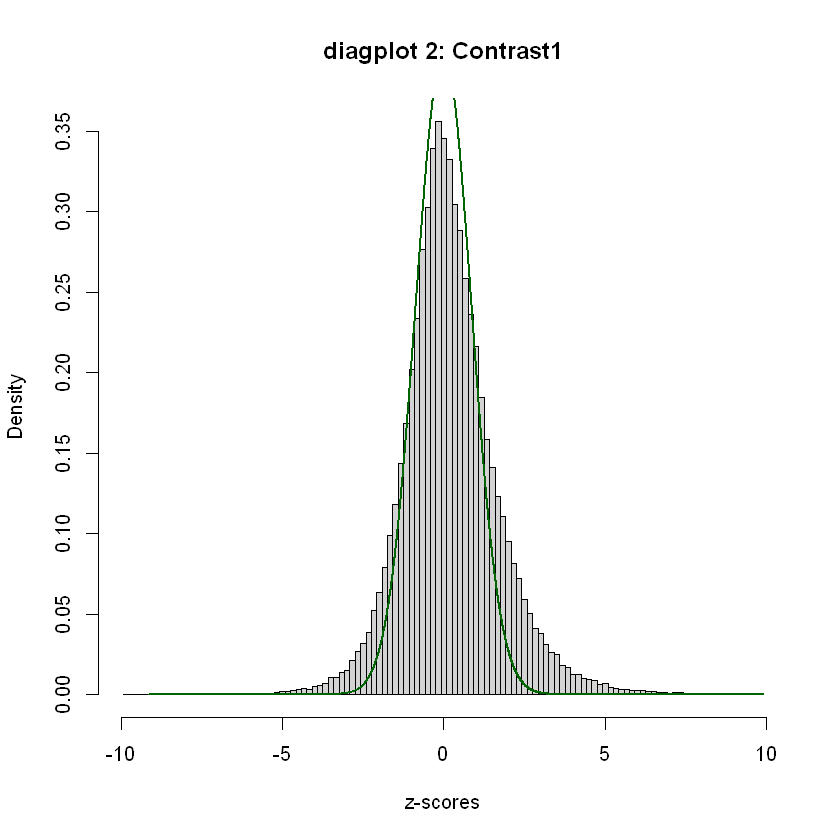

[1] "prad done."


Warning message:
"Zero sample variances detected, have been offset away from zero"


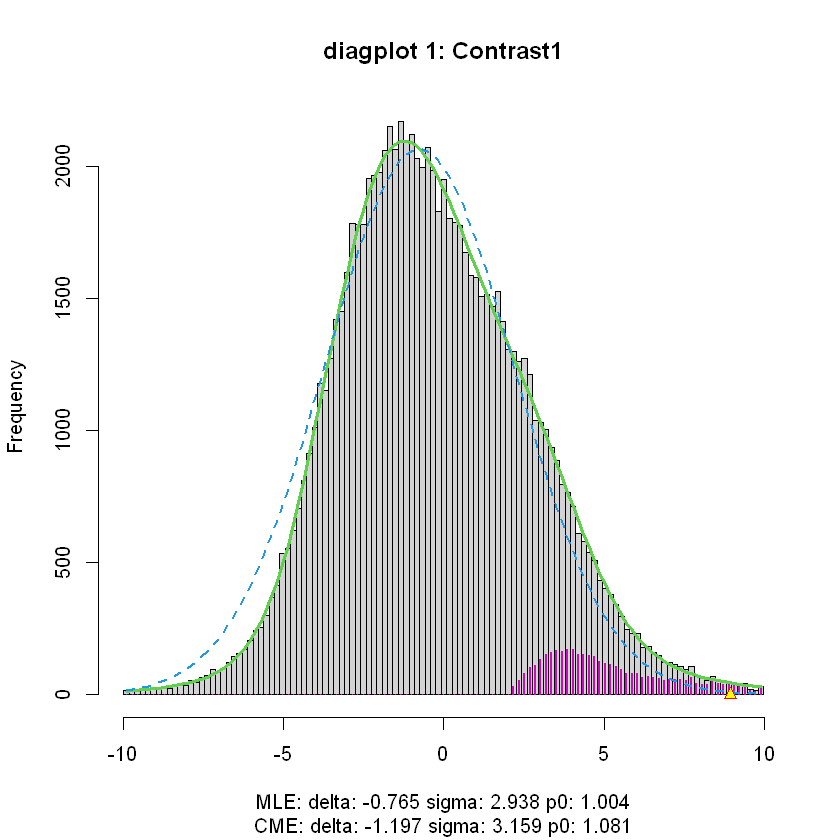

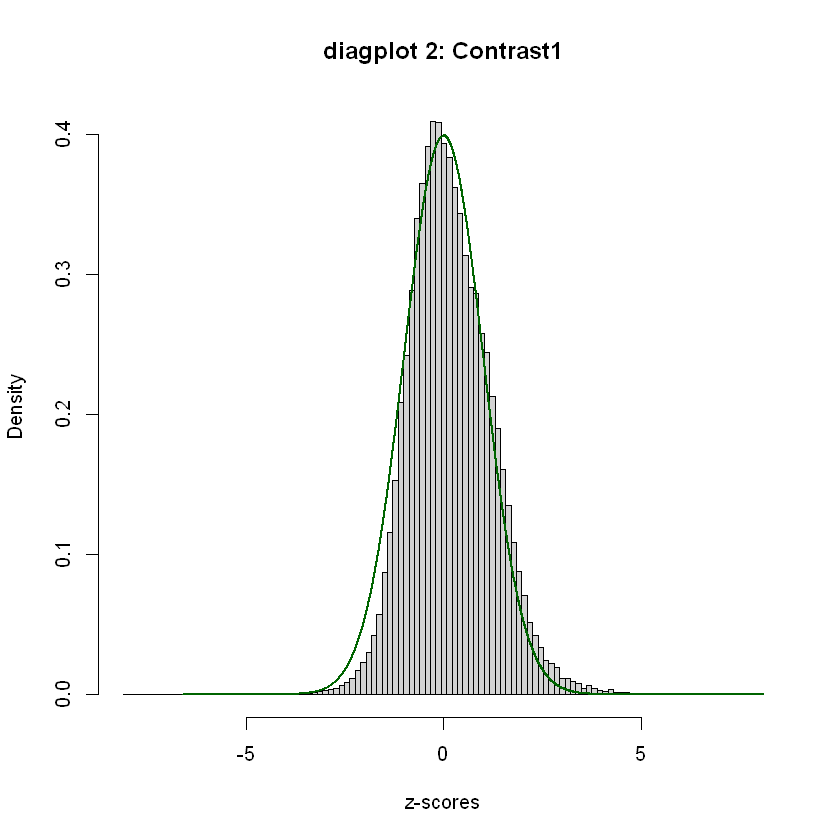

[1] "lusc done."


Warning message:
"Zero sample variances detected, have been offset away from zero"
Warning message in locfdr(zz = zvalues_mid, main = paste0("diagplot 1: ", main)):
"f(z) misfit = 1.9.  Rerun with increased df"


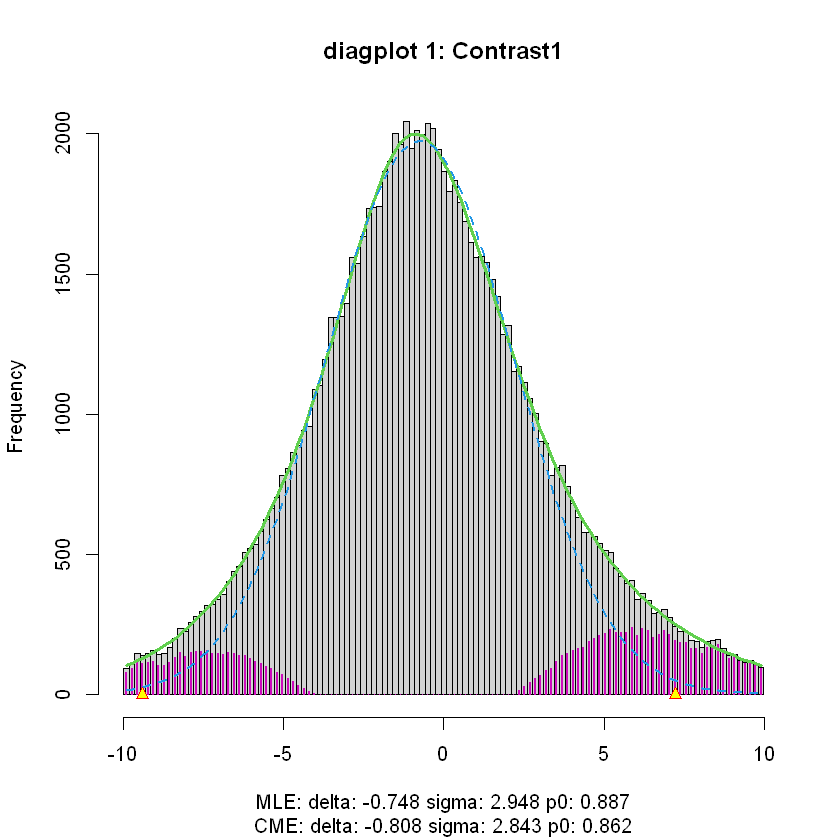

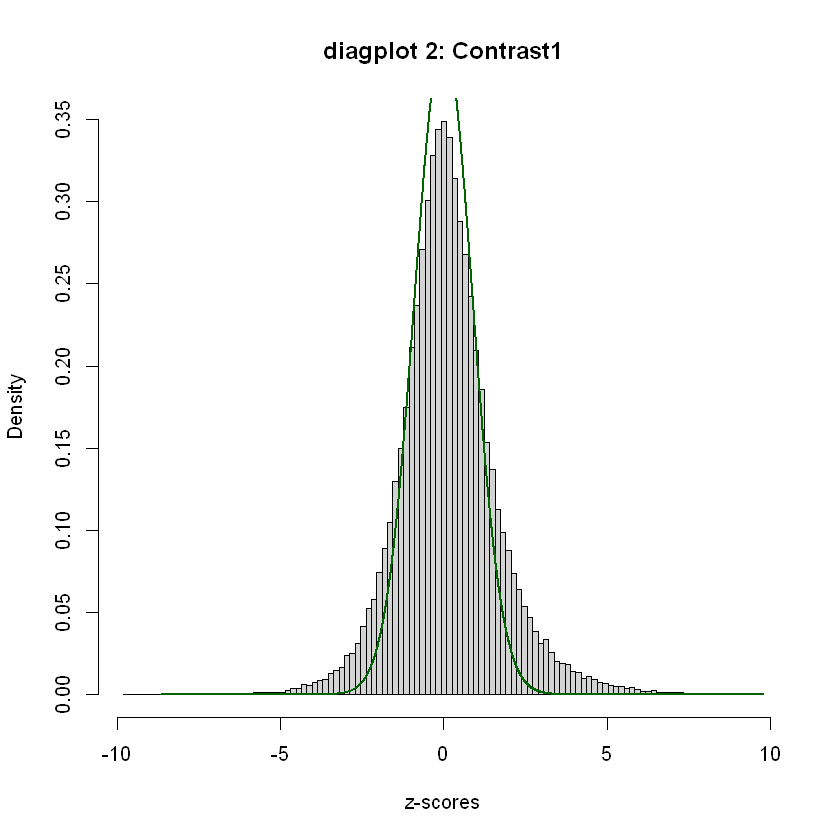

[1] "lihc done."


Warning message:
"Zero sample variances detected, have been offset away from zero"
Warning message in locfdr(zz = zvalues_mid, main = paste0("diagplot 1: ", main)):
"f(z) misfit = 1.8.  Rerun with increased df"


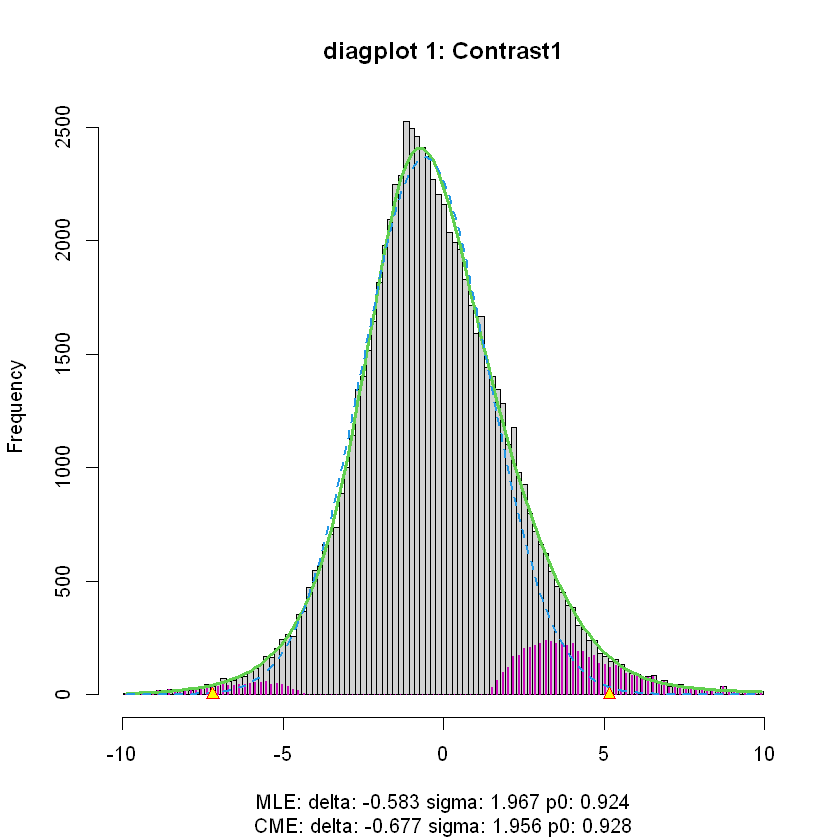

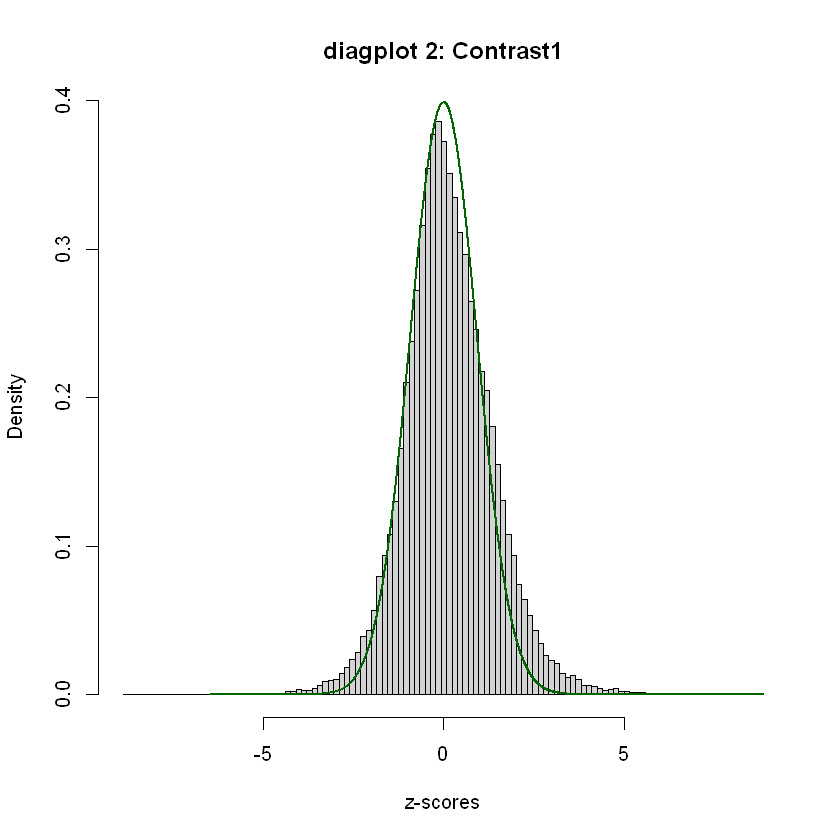

[1] "hnsc done."


Warning message:
"Zero sample variances detected, have been offset away from zero"
Warning message in locfdr(zz = zvalues_mid, main = paste0("diagplot 1: ", main)):
"f(z) misfit = 1.5.  Rerun with increased df"


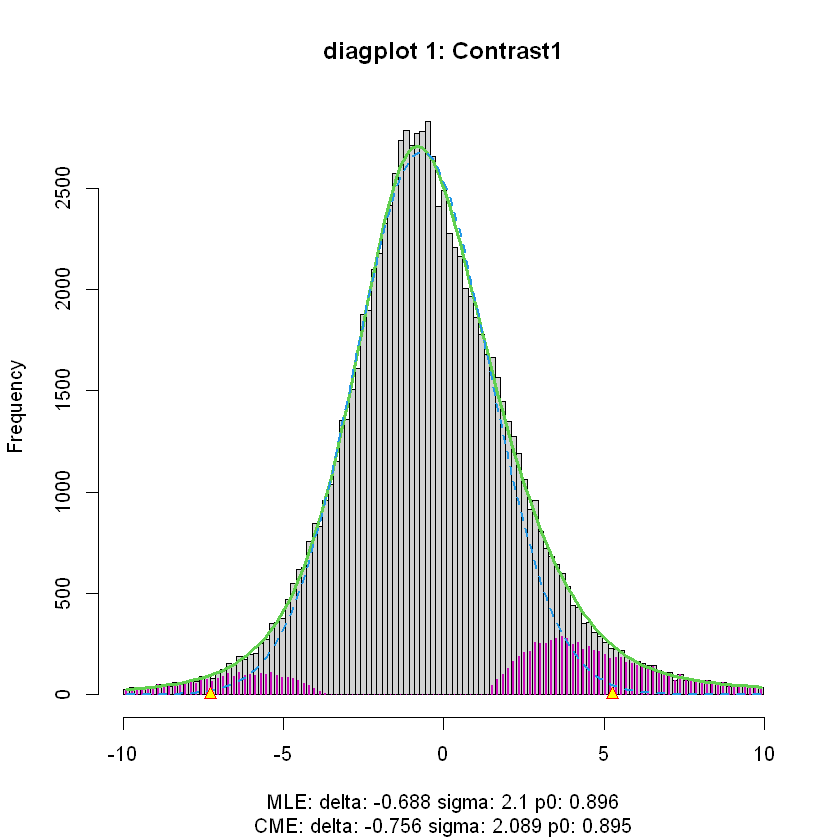

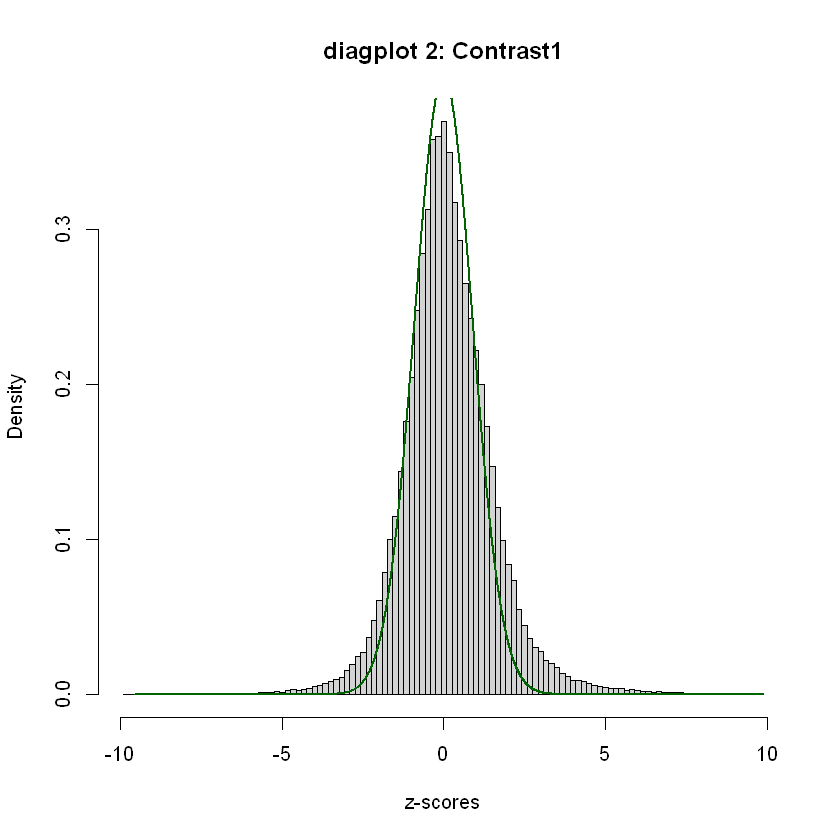

[1] "coad done."


Warning message:
"Zero sample variances detected, have been offset away from zero"


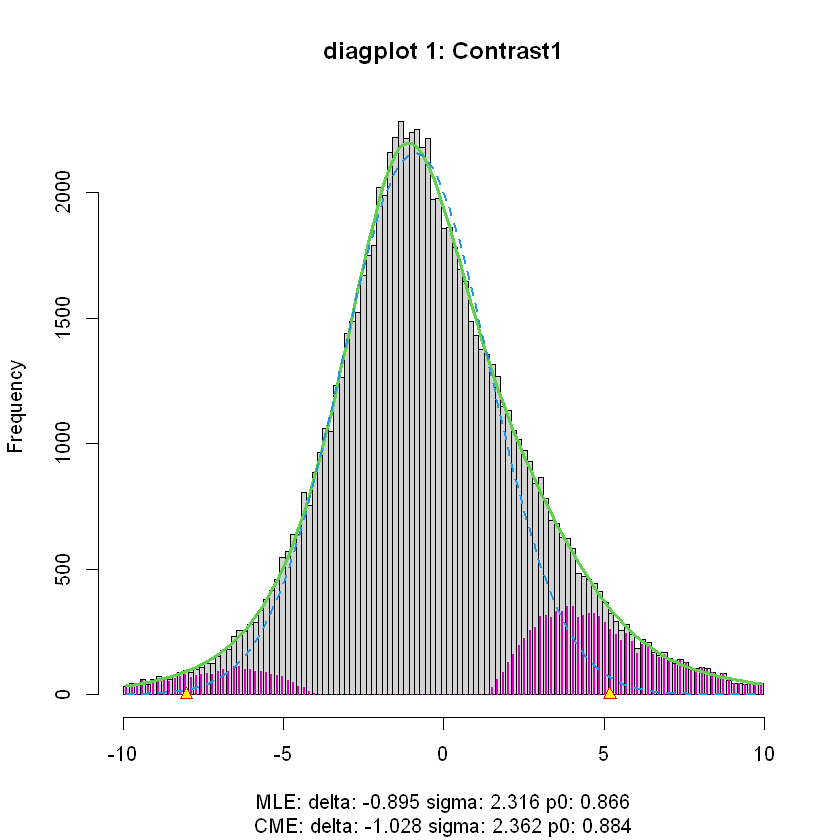

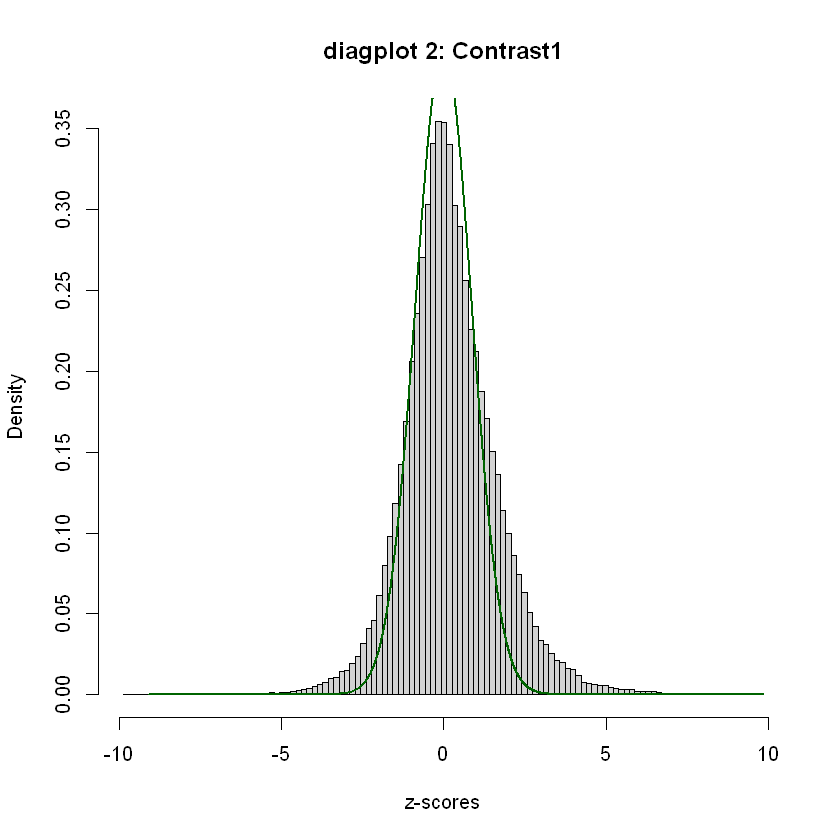

[1] "stad done."


Warning message:
"Zero sample variances detected, have been offset away from zero"


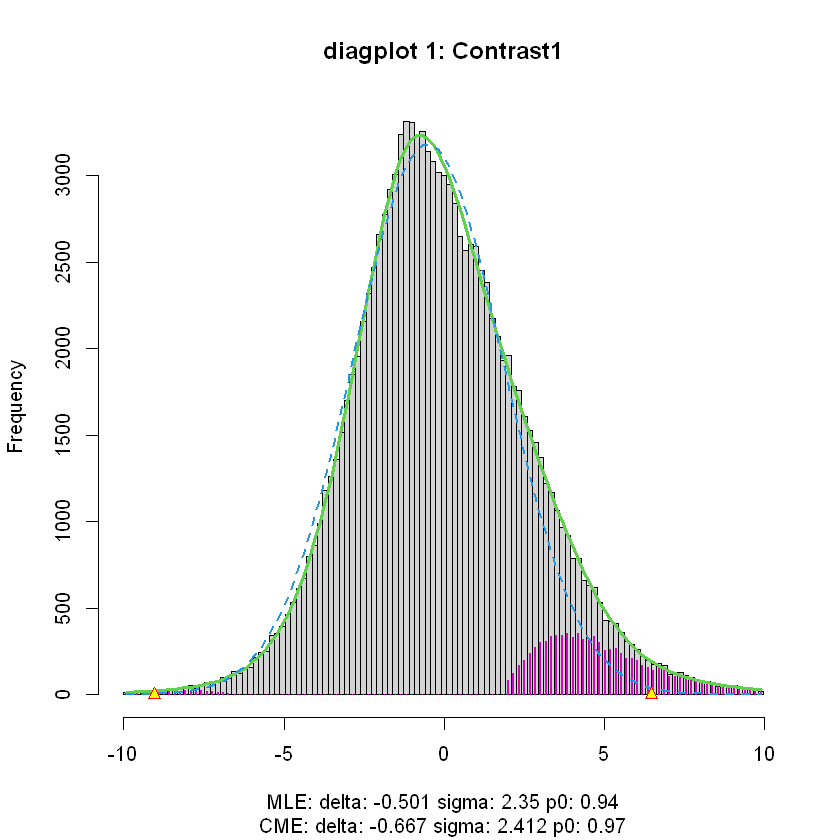

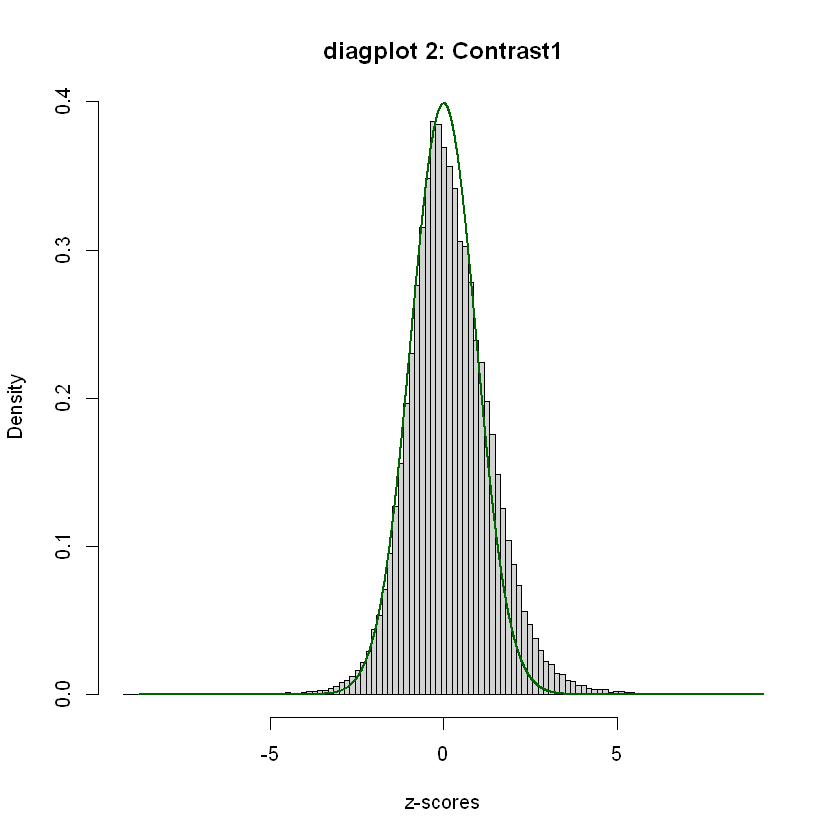

[1] "kirp done."


Warning message:
"Zero sample variances detected, have been offset away from zero"
Warning message in locfdr(zz = zvalues_mid, main = paste0("diagplot 1: ", main)):
"f(z) misfit = 2.  Rerun with increased df"


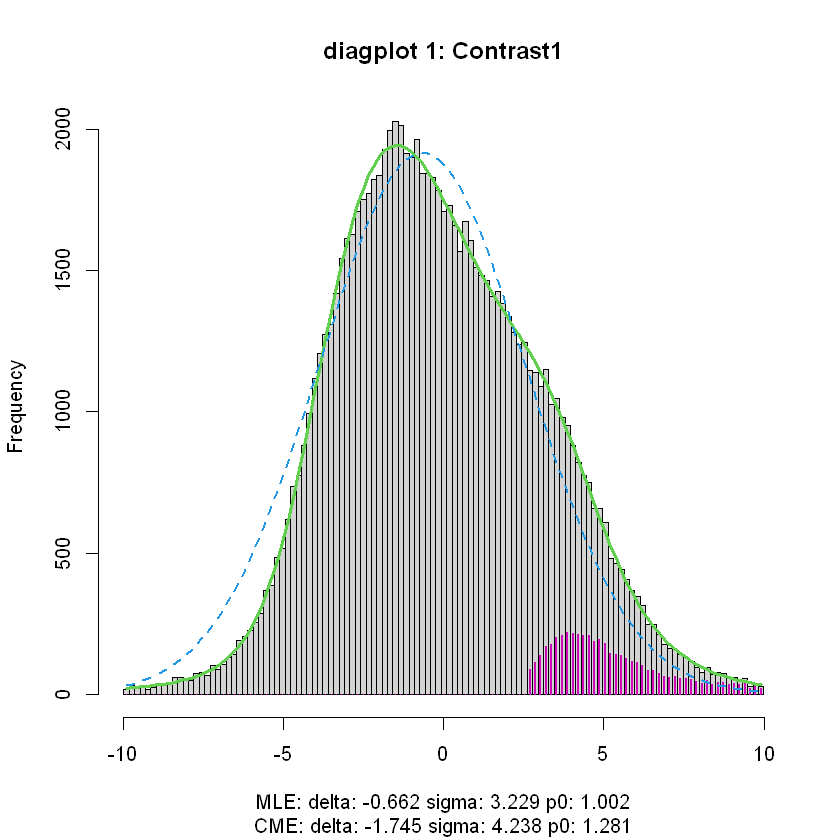

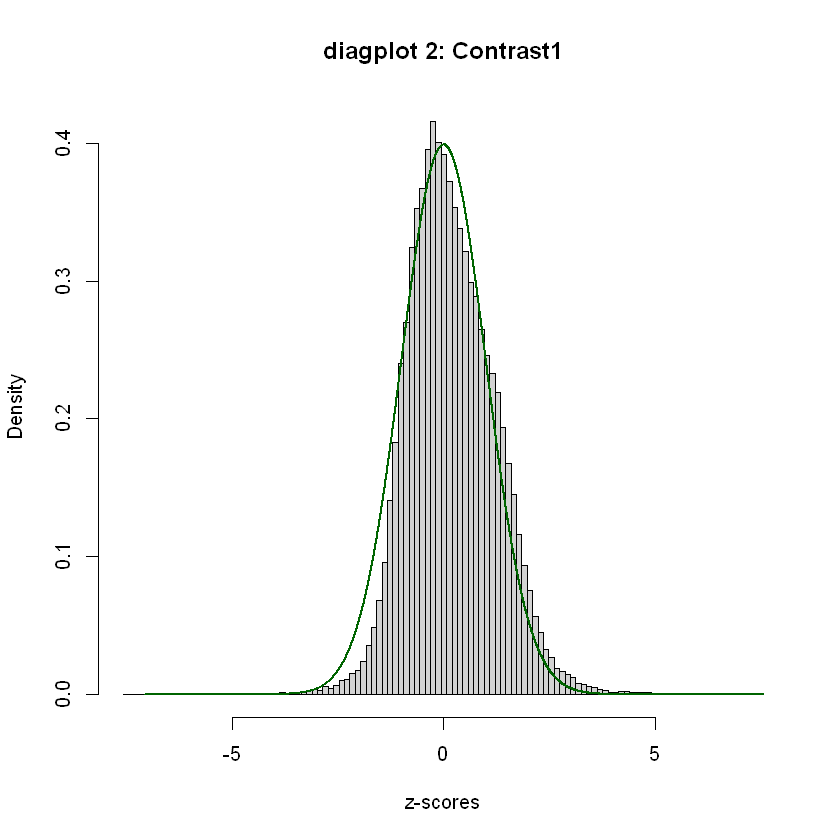

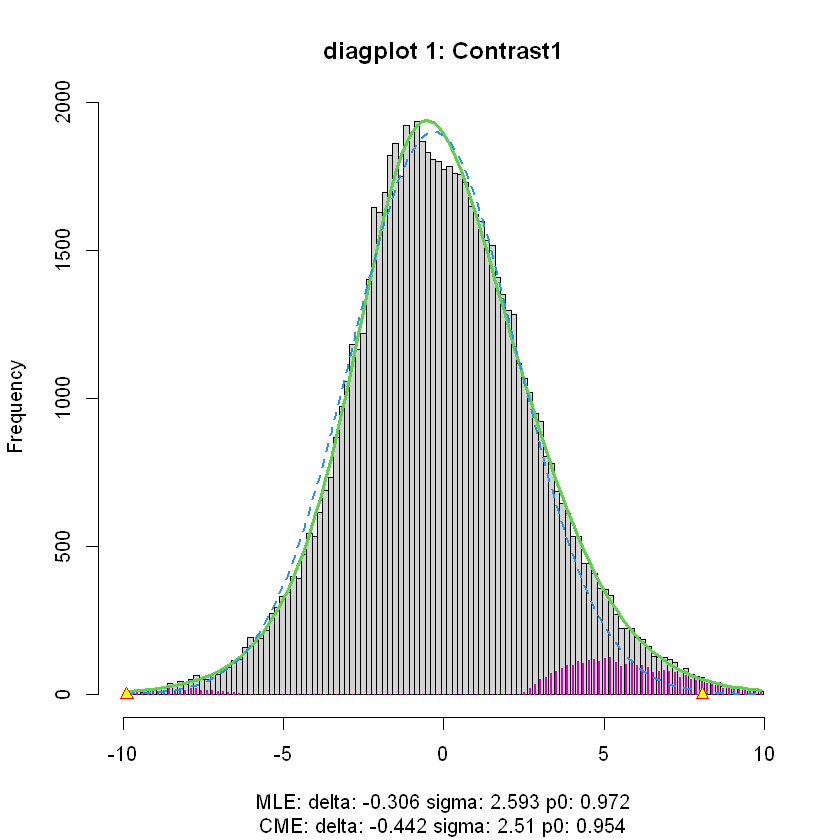

[1] "kich done."


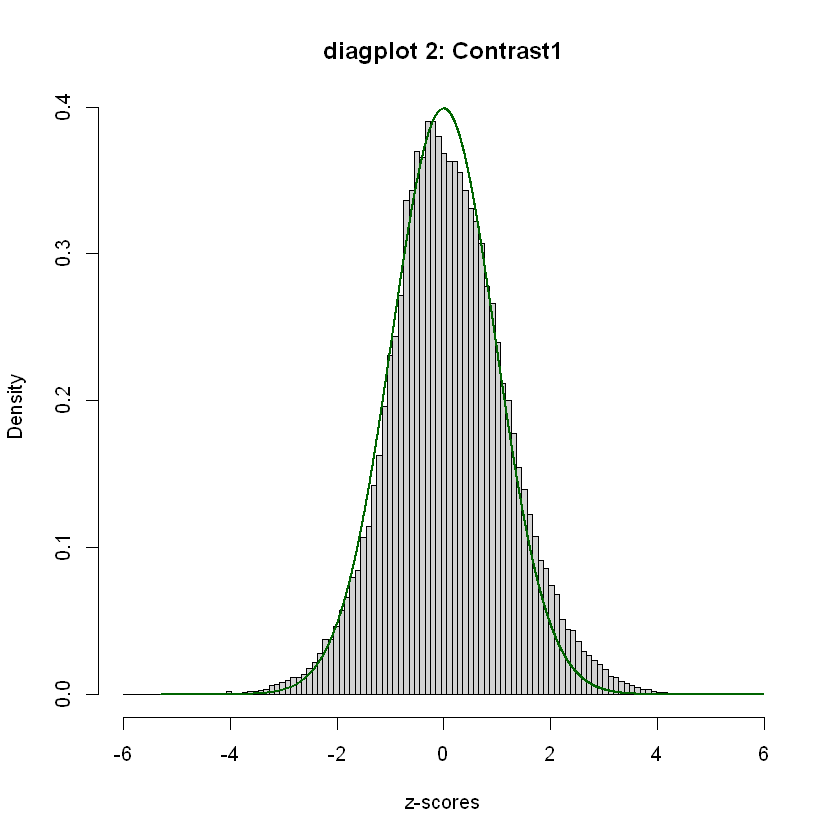

In [7]:
for (ctype in tcga_groups) {
    design_matrix <- readr::read_csv(sprintf("../data/processed/tcga_type_data/%s_dm.csv", ctype), show_col_types = FALSE)
    
    # Samples in design matrix and count matrix need to be in the same order
    design_matrix = design_matrix %>%
        dplyr::arrange(sampleID) %>%
        dplyr::rename(group = condition)
    
    est_counts <- readr::read_csv(sprintf("../data/processed/tcga_type_data/%s_est_counts.csv", ctype), show_col_types = FALSE)

    est_counts = est_counts %>%
        tibble::column_to_rownames("isoform_id") %>%
        dplyr::filter(rownames(.) %in% gtf$isoform_id) %>%
        dplyr::select(order(colnames(.)))
    
    # Default edgeR expression filter as recommended in the SatuRn's vignette
    filter_edgeR <- edgeR::filterByExpr(est_counts, group = design_matrix$group)
    
    est_counts = est_counts %>%
        dplyr::filter(filter_edgeR)
    
    # After filtering by expression, remove genes with one isoform left
    gtf_local = gtf %>%
        dplyr::filter(isoform_id %in% rownames(est_counts)) %>%
        dplyr::filter(duplicated(gene_id) | duplicated(gene_id, fromLast = TRUE))
    
    est_counts = est_counts %>%
        dplyr::filter(rownames(.) %in% gtf_local$isoform_id)
    
    # Transcripts in gtf and count matrix need to be in the same order
    gtf_local = gtf_local %>%
        dplyr::slice(match(rownames(est_counts), gtf_local$isoform_id))
    
    sumExp <- SummarizedExperiment::SummarizedExperiment(
        assays = list(counts = est_counts),
        colData = design_matrix,
        rowData = gtf_local
    )
    
    metadata(sumExp)$formula <- ~ 0 + as.factor(colData(sumExp)$group)
    
    sumExp <- satuRn::fitDTU(
        object = sumExp,
        formula = ~ 0 + group,
        parallel = FALSE,
        BPPARAM = BiocParallel::bpparam(),
        verbose = TRUE
    )
    group <- as.factor(design_matrix$group)
    design <- model.matrix(~ 0 + group) # Construct design matrix
    colnames(design) <- levels(group)

    L <- matrix(0, ncol = 1, nrow = ncol(design)) # Initialize contrast matrix
    rownames(L) <- colnames(design)
    colnames(L) <- c("Contrast1")

    L[c("cancer", "normal"), 1] <- c(1, -1)
    
    sumExp <- satuRn::testDTU(
        object = sumExp,
        contrasts = L,
        sort = TRUE,
        diagplot1 = FALSE,
        diagplot2 = FALSE
    )
    write.csv(rowData(sumExp)[["fitDTUResult_Contrast1"]], sprintf("../results/saturn/%s_saturn.csv", ctype))
    
    message(ctype, " done")
}